In [1]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    get_scheduler
)
from peft import LoraConfig, get_peft_model, TaskType
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
!pip install evaluate
import evaluate
import time
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00


In [2]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# 1. LOAD YOUR DATA (Category-Observation-Recommendation)
# ============================================================================
print("="*80)
print("LOADING DATA")
print("="*80)

df = pd.read_csv('/content/cor_data_10000_up.csv')
# Required columns: 'Category', 'Observation', 'Recommendation'


df = df.dropna()

print(f"Total samples: {len(df)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nCategories: {df['Category'].unique()}")
print(f"\nFirst 3 rows:")
print(df.head(3))

LOADING DATA
Total samples: 10000

Columns: ['Category', 'Observation', 'Recommendation']

Categories: ['Moderate' 'Very Serious' 'Serious']

First 3 rows:
   Category                     Observation  \
0  Moderate  Outdated tools in storage area   
1  Moderate       Dusty supplies in hallway   
2  Moderate         Dusty supplies in lobby   

                                      Recommendation  
0  Update with current information and distribute...  
1  Clean regularly and establish maintenance sche...  
2  Clean regularly and establish maintenance sche...  


In [3]:
# 2. TRAIN-VAL-TEST SPLIT
# ============================================================================
print("\n" + "="*80)
print("DATA SPLITTING")
print("="*80)

# Split data: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")


DATA SPLITTING
Train set: 8000 samples (80.0%)
Validation set: 1000 samples (10.0%)
Test set: 1000 samples (10.0%)


In [4]:
# 3. LOAD MODEL & TOKENIZER
# ============================================================================
print("\n" + "="*80)
print("LOADING FLAN-T5-BASE MODEL")
print("="*80)

model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model: {model_name}")
print(f"Using device: {device}")
print(f"Total parameters: {model.num_parameters():,}")


LOADING FLAN-T5-BASE MODEL


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model: google/flan-t5-base
Using device: cuda
Total parameters: 247,577,856


In [5]:
# 4. LORA CONFIGURATION
# ============================================================================
print("\n" + "="*80)
print("CONFIGURING LORA")
print("="*80)

lora_config = LoraConfig(
    r=16,  # LoRA rank
    lora_alpha=32,  # Scaling factor
    target_modules=["q", "v", "k", "o", "wi", "wo"],  # Attention + FFN layers
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

model = get_peft_model(model, lora_config)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"All parameters: {total_params:,}")
model.print_trainable_parameters()


CONFIGURING LORA
Trainable parameters: 4,620,288 (1.83%)
All parameters: 252,198,144
trainable params: 4,620,288 || all params: 252,198,144 || trainable%: 1.8320


In [6]:
# 5. PREPARE DATA - MULTI-OUTPUT FORMAT
# ============================================================================
print("\n" + "="*80)
print("MULTI-OUTPUT INSTRUCTION FORMATTING")
print("="*80)

max_input_length = 512
max_target_length = 256

def prepare_multi_output_data(df):
    """
    Prepare data in format: Observation -> Category + Recommendation
    Output format: Category: [category] | Recommendation: [recommendation]
    """
    data = []
    for _, row in df.iterrows():
        # Input: observation with instruction
        input_text = f"Given the observation, predict the category and recommendation.\n\nObservation: {row['Observation']}"

        # Output: structured format with both category and recommendation
        target_text = f"Category: {row['Category']} | Recommendation: {row['Recommendation']}"

        data.append({
            'input_text': input_text,
            'target_text': target_text,
            'category': row['Category'],
            'observation': row['Observation'],
            'recommendation': row['Recommendation']
        })
    return data

train_data = prepare_multi_output_data(train_df)
val_data = prepare_multi_output_data(val_df)
test_data = prepare_multi_output_data(test_df)

print(f"Train samples: {len(train_data)}")
print(f"Val samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")
print(f"\nExample input-output pair:")
print(f"INPUT: {train_data[0]['input_text'][:200]}...")
print(f"OUTPUT: {train_data[0]['target_text'][:200]}...")


MULTI-OUTPUT INSTRUCTION FORMATTING
Train samples: 8000
Val samples: 1000
Test samples: 1000

Example input-output pair:
INPUT: Given the observation, predict the category and recommendation.

Observation: Response time increased by 71% in past month...
OUTPUT: Category: Serious | Recommendation: Conduct root cause analysis and implement corrective action plan...


In [20]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# 1. LOAD YOUR DATA (Category-Observation-Recommendation)
# ============================================================================
print("="*80)
print("LOADING DATA")
print("="*80)


df = pd.read_csv('/content/cor_data_10000_up.csv')
# Required columns: 'Category', 'Observation', 'Recommendation'

df = df.dropna()

print(f"Total samples: {len(df)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nCategories: {df['Category'].unique()}")
print(f"\nFirst 3 rows:")
print(df.head(3))# 6. TOKENIZATION
# ============================================================================
print("\n" + "="*80)
print("TOKENIZING DATA")
print("="*80)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples['input_text'],
        max_length=max_input_length,
        truncation=True,
        padding=False # Defer padding to DataCollator
    )

    labels = tokenizer(
        text_target=examples['target_text'],
        max_length=max_target_length,
        truncation=True,
        padding=False # Defer padding to DataCollator
    )

    # Only return the essential tokenized features
    return {
        'input_ids': model_inputs['input_ids'],
        'attention_mask': model_inputs['attention_mask'],
        'labels': labels['input_ids'] # Use labels['input_ids'] for the labels
    }

train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

# Define columns to remove (original text columns and any intermediate ones)
columns_to_remove = ['input_text', 'target_text', 'category', 'observation', 'recommendation']

train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=columns_to_remove)
val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=columns_to_remove)
test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=columns_to_remove)

print(f"Tokenization complete!")
print(f"Train dataset: {train_dataset}")
print(f"Val dataset: {val_dataset}")
print(f"Test dataset: {test_dataset}")

LOADING DATA
Total samples: 10000

Columns: ['Category', 'Observation', 'Recommendation']

Categories: ['Moderate' 'Very Serious' 'Serious']

First 3 rows:
   Category                     Observation  \
0  Moderate  Outdated tools in storage area   
1  Moderate       Dusty supplies in hallway   
2  Moderate         Dusty supplies in lobby   

                                      Recommendation  
0  Update with current information and distribute...  
1  Clean regularly and establish maintenance sche...  
2  Clean regularly and establish maintenance sche...  

TOKENIZING DATA


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenization complete!
Train dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 8000
})
Val dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})
Test dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})


In [21]:
# 7. DATA LOADERS
# ============================================================================

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    label_pad_token_id=-100
)

batch_size = 8
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_dataloader)}")
print(f"Val batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Batch size: 8
Train batches: 1000
Val batches: 125
Test batches: 125


In [22]:
!pip install sacrebleu
!pip install rouge_score
!pip install bert_score

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

In [23]:
# 8. EVALUATION METRICS SETUP
# ============================================================================
print("\n" + "="*80)
print("LOADING EVALUATION METRICS")
print("="*80)

bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")


LOADING EVALUATION METRICS


In [24]:
# 9. OPTIMIZER & SCHEDULER
# ============================================================================
print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

num_epochs = 10  # Increase for better results
num_training_steps = num_epochs * len(train_dataloader)
num_warmup_steps = 100

lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

print(f"Epochs: {num_epochs}")
print(f"Training steps: {num_training_steps}")
print(f"Warmup steps: {num_warmup_steps}")
print(f"Learning rate: 3e-4")


TRAINING CONFIGURATION
Epochs: 10
Training steps: 10000
Warmup steps: 100
Learning rate: 3e-4


In [25]:
# 10. TRAINING LOOP
# ============================================================================
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

start_time = time.time()
best_val_loss = float('inf')
training_losses = []
validation_losses = []

model.to(device)

for epoch in range(num_epochs):
    # ========================================
    # TRAINING
    # ========================================
    model.train()
    total_train_loss = 0
    train_steps = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()
        train_steps += 1
        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_train_loss / train_steps
    training_losses.append(avg_train_loss)
    print(f"\nEpoch {epoch+1} - Avg Training Loss: {avg_train_loss:.4f}")


STARTING TRAINING


Epoch 1/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 1 - Avg Training Loss: 0.4972


Epoch 2/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 2 - Avg Training Loss: 0.0104


Epoch 3/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 3 - Avg Training Loss: 0.0048


Epoch 4/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 4 - Avg Training Loss: 0.0023


Epoch 5/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 5 - Avg Training Loss: 0.0015


Epoch 6/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 6 - Avg Training Loss: 0.0008


Epoch 7/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 7 - Avg Training Loss: 0.0007


Epoch 8/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 8 - Avg Training Loss: 0.0004


Epoch 9/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 9 - Avg Training Loss: 0.0003


Epoch 10/10 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 10 - Avg Training Loss: 0.0003


In [26]:
    # ========================================
    # VALIDATION
    # ========================================
    model.eval()
    total_val_loss = 0
    val_steps = 0

    print(f"\nValidating...")
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()
            val_steps += 1

    avg_val_loss = total_val_loss / val_steps
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Avg Validation Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained("./flan-t5-multi-output-lora-best")
        print(f"✓ Best model saved! (val_loss: {best_val_loss:.4f})")

    print("="*80)

training_time = time.time() - start_time
print(f"\nTotal training time: {training_time/60:.2f} minutes")

# Save final model
model.save_pretrained("./flan-t5-multi-output-lora-final")
tokenizer.save_pretrained("./flan-t5-multi-output-lora-final")
print(f"Final model saved!")


Validating...


Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10 - Avg Validation Loss: 0.0000
✓ Best model saved! (val_loss: 0.0000)

Total training time: 35.42 minutes
Final model saved!


In [28]:
# 11. EVALUATION ON TEST SET
# ============================================================================
print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80)

# Load best model
print("Loading best model...")
from peft import PeftModel
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model = PeftModel.from_pretrained(base_model, "./flan-t5-multi-output-lora-best")
model.to(device)
model.eval()

all_predictions = []
all_references = []
predicted_categories = []
true_categories = []

# Evaluate on all test samples
test_sample = test_data

print(f"Generating predictions for {len(test_sample)} test samples...")
for example in tqdm(test_sample):
    input_ids = tokenizer(
        example['input_text'],
        return_tensors="pt",
        max_length=max_input_length,
        truncation=True
    ).input_ids.to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids, # Pass input_ids as a keyword argument
            max_length=max_target_length,
            num_beams=4,
            early_stopping=True
        )

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    all_predictions.append(prediction)
    all_references.append(example['target_text'])

    # Extract predicted category
    try:
        pred_cat = prediction.split('|')[0].replace('Category:', '').strip()
        predicted_categories.append(pred_cat)
    except:
        predicted_categories.append('')

    true_categories.append(example['category'])

print(f"Predictions generated!")


EVALUATING ON TEST SET
Loading best model...
Generating predictions for 1000 test samples...


  0%|          | 0/1000 [00:00<?, ?it/s]

Predictions generated!


In [34]:
# 12. CALCULATE METRICS
# ============================================================================
print("\n" + "="*80)
print("CALCULATING METRICS")
print("="*80)

from sklearn.metrics import accuracy_score, classification_report

# Category accuracy
category_accuracy = accuracy_score(true_categories, predicted_categories)

# BLEU score
bleu_result = bleu_metric.compute(
    predictions=all_predictions,
    references=[[ref] for ref in all_references]
)

# ROUGE score
rouge_result = rouge_metric.compute(
    predictions=all_predictions,
    references=all_references
)

# Exact match
exact_match = sum([pred == ref for pred, ref in zip(all_predictions, all_references)]) / len(all_predictions) * 100

# BERTScore
print("Computing BERTScore (this may take a moment)...")
bertscore_result = bertscore_metric.compute(
    predictions=all_predictions,
    references=all_references,
    lang="en"
)

print("\nMetrics calculated!")


CALCULATING METRICS
Computing BERTScore (this may take a moment)...

Metrics calculated!


In [30]:
# 13. FINAL RESULTS
# ============================================================================
print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)

print(f"\nCATEGORY PREDICTION:")
print(f"  Accuracy: {category_accuracy*100:.2f}%")

print(f"\n RECOMMENDATION QUALITY:")
print(f"  BLEU-4: {bleu_result['score']:.2f}")
print(f"  ROUGE-1: {rouge_result['rouge1']:.4f}")
print(f"  ROUGE-2: {rouge_result['rouge2']:.4f}")
print(f"  ROUGE-L: {rouge_result['rougeL']:.4f}")
print(f"  Exact Match: {exact_match:.2f}%")
print(f"  BERTScore F1: {np.mean(bertscore_result['f1'])*100:.2f}")

print(f"\n CATEGORY CLASSIFICATION REPORT:")
print(classification_report(true_categories, predicted_categories))

print("="*80)


FINAL RESULTS

CATEGORY PREDICTION:
  Accuracy: 100.00%

 RECOMMENDATION QUALITY:
  BLEU-4: 100.00
  ROUGE-1: 1.0000
  ROUGE-2: 1.0000
  ROUGE-L: 1.0000
  Exact Match: 100.00%
  BERTScore F1: 100.00

 CATEGORY CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Moderate       1.00      1.00      1.00       565
     Serious       1.00      1.00      1.00       276
Very Serious       1.00      1.00      1.00       159

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [31]:
# 14. SAMPLE PREDICTIONS
# ============================================================================
print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

for i in range(min(5, len(test_sample))):
    example = test_sample[i]

    print(f"\n--- Example {i+1} ---")
    print(f"Observation: {example['observation']}")
    print(f"\nGround Truth:")
    print(f"  Category: {example['category']}")
    print(f"  Recommendation: {example['recommendation']}")
    print(f"\nPrediction: {all_predictions[i]}")

    # Parse prediction
    try:
        parts = all_predictions[i].split('|')
        pred_cat = parts[0].replace('Category:', '').strip()
        pred_rec = parts[1].replace('Recommendation:', '').strip()
        print(f"Parsed Prediction:")
        print(f"  Category: {pred_cat} {'✓' if pred_cat == example['category'] else '✗'}")
        print(f"  Recommendation: {pred_rec}")
    except:
        print(f"Could not parse prediction")

    print("="*80)


SAMPLE PREDICTIONS

--- Example 1 ---
Observation: Chipped supplies in break room

Ground Truth:
  Category: Moderate
  Recommendation: Repair or replace to maintain appearance

Prediction: Category: Moderate | Recommendation: Repair or replace to maintain appearance
Parsed Prediction:
  Category: Moderate ✓
  Recommendation: Repair or replace to maintain appearance

--- Example 2 ---
Observation: Broken tools in break room

Ground Truth:
  Category: Moderate
  Recommendation: Replace immediately and inspect similar items

Prediction: Category: Moderate | Recommendation: Replace immediately and inspect similar items
Parsed Prediction:
  Category: Moderate ✓
  Recommendation: Replace immediately and inspect similar items

--- Example 3 ---
Observation: Broken records in warehouse

Ground Truth:
  Category: Moderate
  Recommendation: Replace immediately and inspect similar items

Prediction: Category: Moderate | Recommendation: Replace immediately and inspect similar items
Parsed Predic


PLOTTING TRAINING CURVES


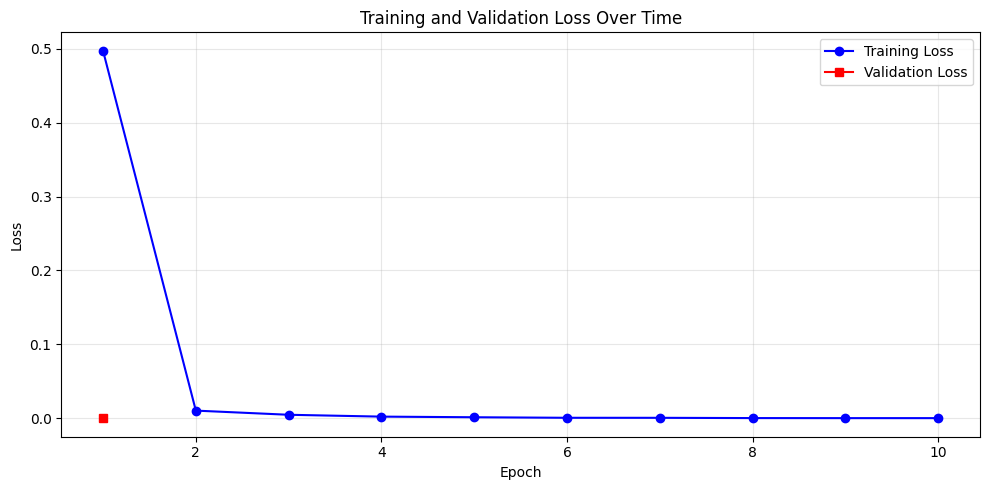

Training curves saved as 'training_curves.png'


In [32]:
# 15. PLOT TRAINING CURVES
# ============================================================================
print("\n" + "="*80)
print("PLOTTING TRAINING CURVES")
print("="*80)

plt.figure(figsize=(10, 5))
epochs_range = range(1, num_epochs + 1)

# Plot Training Loss
if training_losses:
    plt.plot(epochs_range[:len(training_losses)], training_losses, 'b-', label='Training Loss', marker='o')

# Plot Validation Loss
if validation_losses:
    plt.plot(epochs_range[:len(validation_losses)], validation_losses, 'r-', label='Validation Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training curves saved as 'training_curves.png'")

In [35]:
# 16. INFERENCE FUNCTION FOR NEW OBSERVATIONS
# ============================================================================
print("\n" + "="*80)
print("INFERENCE FUNCTION READY")
print("="*80)

def predict_category_and_recommendation(observation, model, tokenizer):
    """
    Predict category and recommendation from a new observation
    """
    # Create input text
    input_text = f"Given the observation, predict the category and recommendation.\n\nObservation: {observation}"

    # Tokenize
    input_ids = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=max_input_length,
        truncation=True
    ).input_ids.to(device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids, # Pass input_ids as a keyword argument
            max_length=max_target_length,
            num_beams=4,
            early_stopping=True
        )

    # Decode
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Parse output
    try:
        parts = prediction.split('|')
        category = parts[0].replace('Category:', '').strip()
        recommendation = parts[1].replace('Recommendation:', '').strip()
        return category, recommendation
    except:
        return "Unable to parse", prediction

# Test the function
print("\nTesting inference function:")
test_observation = "Equipment running without proper guarding in place"
pred_cat, pred_rec = predict_category_and_recommendation(test_observation, model, tokenizer)
print(f"\nObservation: {test_observation}")
print(f"Predicted Category: {pred_cat}")
print(f"Predicted Recommendation: {pred_rec}")


INFERENCE FUNCTION READY

Testing inference function:

Observation: Equipment running without proper guarding in place
Predicted Category: Moderate
Predicted Recommendation: Replace with new professional materials


In [36]:
# 17. SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print(f"\nModel saved to: ./flan-t5-multi-output-lora-final")
print(f"Training time: {training_time/60:.2f} minutes")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"\nBest model performance on test set ({len(test_sample)} samples):")
print(f"  Category Accuracy: {category_accuracy*100:.2f}%")
print(f"  BLEU-4: {bleu_result['score']:.2f}")
print(f"  ROUGE-L: {rouge_result['rougeL']:.4f}")
print(f"  Exact Match: {exact_match:.2f}%")
print(f"  BERTScore F1: {np.mean(bertscore_result['f1'])*100:.2f}")
print("="*80)
print("\nYou can now use the model to predict categories and recommendations!")
print("Use: predict_category_and_recommendation(observation, model, tokenizer)")


PIPELINE COMPLETE!

Model saved to: ./flan-t5-multi-output-lora-final
Training time: 35.42 minutes
Trainable parameters: 4,620,288 (1.83%)

Best model performance on test set (1000 samples):
  Category Accuracy: 100.00%
  BLEU-4: 100.00
  ROUGE-L: 1.0000
  Exact Match: 100.00%
  BERTScore F1: 100.00

You can now use the model to predict categories and recommendations!
Use: predict_category_and_recommendation(observation, model, tokenizer)
